# Unit 1 - Modelling and Representations of Systems
# Part 4 - Frequency Domain

- Modelling of electrical and mechanical systems
    - Electric circuits with resistors, capacitors, inductors, op-amps
    - Translational mechanical systems
    - Rotational mechanical systems
- Representations
    - Frequency domain
- Key Concept
    - Poles
    - Zeros
- Plots
    - Bode

![Fourier](Fourier.jpg "Fourier")
source: https://en.wikipedia.org/wiki/Joseph_Fourier
- March 21 1768 - May 16 1830
- Fourier accompanied Napoleon Bonaparte on his Egyptian expedition in 1798, as scientific adviser
- Known for initiating the investigation of Fourier series
- Applications to problems of heat transfer and vibrations


![Bode](Hendrik_Wade_Bode.png "Bode")
source: https://en.wikipedia.org/wiki/Hendrik_Wade_Bode
- December 24 1905 - June 21 2982
- pioneer of modern control theory and electronic telecommunications 
- His synergy with Claude Shannon, the father of information theory, laid the foundations for the technological convergence of the information age
- Contributions to the design, guidance and control of anti-aircraft systems during World War II
- During the Cold War, he contributed to the design and control of missiles and anti-ballistic missiles



# In Class Activity!

- Look at the Bode plots of various systems
    - Second order
    - systems with large poles, small zeros, and vice-versa
    - Higher order
    - Unstable systems
    - Non-Minimum phase systems

In [ ]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import enel441_utilities as eu

def enel441_get_reasonable_freq_range(num, den, N):
    roots_den = np.roots(den)
    den_corner_freqs = np.abs(roots_den)
    
    if num.shape[0]>1:
        roots_num = np.roots(num)   
        num_corner_freqs = np.abs(roots_num)
        omega_min = np.min( [np.min(den_corner_freqs), np.min(num_corner_freqs)] )
        omega_max = np.max( [np.max(den_corner_freqs), np.max(num_corner_freqs)] )
    else:
        omega_min = np.min(den_corner_freqs)
        omega_max = np.max(den_corner_freqs)
        
    omega = np.logspace(np.log10(omega_min/100),np.log10(omega_max*100),num=N)
    return omega


def enel441_fourier_transform(num,den,omega):

    G_jw = np.zeros(N,dtype=np.csingle)
       
    ii = 0
    for w in omega:
        jomega = 1j*w
        num_jw = 0
        jj = num.shape[0] - 1
        for nn in num:
            num_jw += nn*(jomega**jj)
            jj -= 1
        
        den_jw = 0
        jj = den.shape[0] - 1
        for dd in den:
            den_jw += dd*(jomega**jj)
            jj -= 1
        #print(den_jw)
        #print(num_jw)
        G_jw[ii] = num_jw/den_jw
        ii += 1
    return G_jw

def find_nearest(arr, value):
    idx = (np.abs(arr - value)).argmin()
    return idx


def enel441_approximate_bode(num_sys,den_sys,omega):
    N = omega.shape[0]
    
    roots_den = np.roots(den_sys)
    den_corner_freqs = np.abs(roots_den)
    num_poles = roots_den.shape[0]
    
    if num_sys.shape[0]>1:
        roots_num = np.roots(num_sys)
        num_corner_freqs = np.abs(roots_num)
        num_zeros = roots_num.shape[0] 
    else:
        num_zeros = 0
        num_corner_freqs = []
        roots_num = []

    # calculate DC offset
    dc_offset = num_sys[0]/den_sys[0]
    for rr in roots_den:
        dc_offset /= rr

    for rr in roots_num:
        dc_offset *= rr

    dc_offset = 20*np.log10(np.abs(dc_offset))


    pole_approx_mag = np.zeros((N,num_poles))
    pole_approx_phase = np.zeros((N,num_poles))
    slope_neg = -20*np.log10(omega)
    ii = 0
    print(num_poles)
    print(den_corner_freqs)
    for cf in den_corner_freqs:
        corner_idx = find_nearest(omega,cf)
        pole_approx_mag[corner_idx:N,ii] = slope_neg[corner_idx:N] - slope_neg[corner_idx]
        p1 = find_nearest(omega,cf/10)
        p2 = find_nearest(omega,cf*10)
        pole_approx_phase[p1:p2,ii] = -np.linspace(0,math.pi/2,p2-p1)
        pole_approx_phase[p2:N,ii] = -math.pi/2
        ii += 1

    zero_approx_mag = np.zeros((N,num_zeros))
    zero_approx_phase = np.zeros((N,num_zeros))
    slope_pos = 20*np.log10(omega)
    ii = 0
    for cf in num_corner_freqs:
        corner_idx = find_nearest(omega,cf)
        zero_approx_mag[corner_idx:N,ii] = slope_pos[corner_idx:N] - slope_pos[corner_idx]
        p1 = find_nearest(omega,cf/10)
        p2 = find_nearest(omega,cf*10)
        zero_approx_phase[p1:p2,ii] = np.linspace(0,math.pi/2,p2-p1)
        zero_approx_phase[p2:N,ii] = math.pi/2
        ii += 1

    approx_response_mag = np.sum(pole_approx_mag, axis=1) + np.sum(zero_approx_mag, axis=1) + dc_offset
    approx_response_phase = np.sum(pole_approx_phase, axis=1) + np.sum(zero_approx_phase, axis=1)

    fig, ax = plt.subplots(num_poles+num_zeros+1,2, figsize=(6.4*2,(num_poles+num_zeros+1)*2))
    for ii in range(num_poles):
        ax[ii,0].semilogx(omega,pole_approx_mag[:,ii], label='pole={:.2f}'.format(roots_den[ii]))
        ax[ii,0].legend()
        ax[ii,0].set_xlabel('Frequency (rad)')
        ax[ii,0].set_ylabel('Mag (dB)')
        ax[ii,0].set_title('Magnitude - Pole Approximation')

        ax[ii,1].semilogx(omega,pole_approx_phase[:,ii], label='pole={:.2f}'.format(roots_den[ii]))
        ax[ii,1].legend()
        ax[ii,1].set_xlabel('Frequency (rad)')
        ax[ii,1].set_ylabel('Freq (rad)')
        ax[ii,1].set_title('Phase - Pole Approximation')

    for ii in range(num_zeros):
        ax[num_poles+ii,0].semilogx(omega,zero_approx_mag[:,ii], label='zero={:.2f}'.format(roots_num[ii]))
        ax[num_poles+ii,0].legend()
        ax[num_poles+ii,0].set_xlabel('Frequency (rad)')
        ax[num_poles+ii,0].set_ylabel('Mag (dB)')
        ax[num_poles+ii,0].set_title('Magnitude - Zero Approximation')

        ax[num_poles+ii,1].semilogx(omega,zero_approx_phase[:,ii], label='zero={:.2f}'.format(roots_num[ii]))
        ax[num_poles+ii,1].legend()
        ax[num_poles+ii,1].set_xlabel('Frequency (rad)')
        ax[num_poles+ii,1].set_ylabel('Freq (rad)')
        ax[num_poles+ii,1].set_title('Phase - Zero Approximation')

    G_jw = enel441_fourier_transform(num_sys,den_sys,omega)
    ax[num_poles+num_zeros,0].semilogx(omega,20*np.log10(np.absolute(G_jw)), label='Actual')
    ax[num_poles+num_zeros,0].semilogx(omega,approx_response_mag, label='Approximation')
    ax[num_poles+num_zeros,0].set_title('Magnitude Response of System')
    ax[num_poles+num_zeros,0].set_xlabel('Frequency (rad)')
    ax[num_poles+num_zeros,0].set_ylabel('Magnitude (dB)')
    ax[num_poles+num_zeros,0].legend()

    ax[num_poles+num_zeros,1].semilogx(omega,np.angle(G_jw), label='Actual')
    ax[num_poles+num_zeros,1].semilogx(omega,approx_response_phase, label='Approximation')
    ax[num_poles+num_zeros,1].set_title('Phase Response of System')
    ax[num_poles+num_zeros,1].set_xlabel('Frequency (rad)')
    ax[num_poles+num_zeros,1].set_ylabel('Phase (rad)')
    ax[num_poles+num_zeros,1].legend()

    fig.tight_layout(pad=1.5)
    plt.show()

2
[22.38302929 22.38302929]


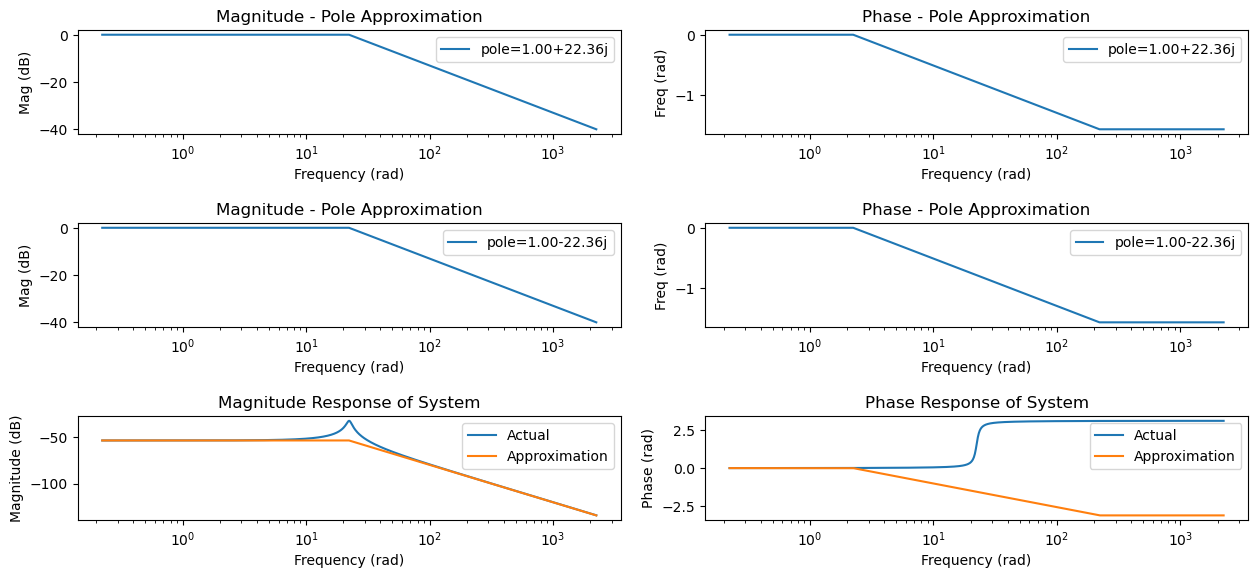

In [46]:
# Try different systems

# Second order systems:
# Real poles/zeros:
# num = eu.roots_to_polynomial([1])
# den = eu.roots_to_polynomial([3, 10])

# Copmlex poles/zeros:
# vary value of imaginary part of the pole. What happens to the actual vs approximate responses?
p_im = 1
num = np.array([1])
den = eu.roots_to_polynomial([complex(1,p_im), complex(1,-5)])

# Higher order
# Try a chebyshev low pass filter
# num, den = sp.signal.cheby1(4, 20, 0.9, analog=True)
# print(num)
# print(den)
# print(np.roots(den))

# Unstable systems
# Non-Minimum phase systems


N = 1000
omega = enel441_get_reasonable_freq_range(num, den, N)
G_jw = enel441_fourier_transform(num,den,omega)
enel441_approximate_bode(num,den,omega)

# In Class Activity!

Add an annotation to the bode plot function that marks the corner frequencies on the plots with a star. What are the corner frequencies again?


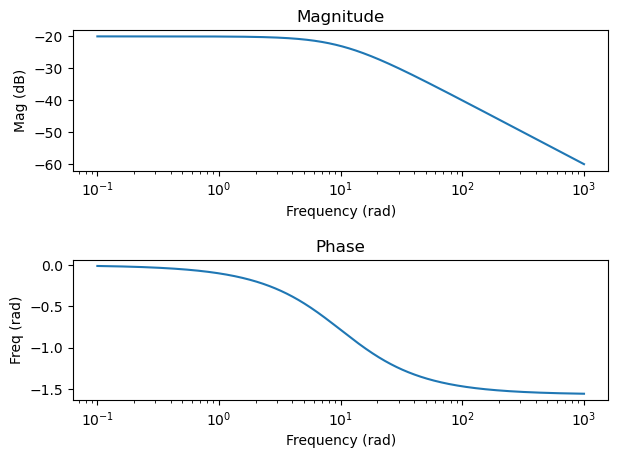

In [57]:
def enel441_annotated_bode_plot(num, den, omega):

    # Add code here to calculate the corner frequencies related to the numerator and denominator.
    # If there are no corner frequencies associated with the numerator, pass an empty numpy array: num_corner_freqs = np.array([])
    
    # Replace the following two lines with your block of code        
    den_corner_freqs = np.array([])
    num_corner_freqs = np.array([])
    
    corner_freq_indeces_poles = np.zeros(den_corner_freqs.shape[0], dtype=int)
    ii = 0
    for cf in den_corner_freqs:
        corner_freq_indeces_poles[ii] = find_nearest(omega,cf)
        ii += 1
    
    corner_freq_indeces_zeros = np.zeros(num_corner_freqs.shape[0],dtype=int)
    ii = 0
    for cf in num_corner_freqs:
        corner_freq_indeces_zeros[ii] = find_nearest(omega,cf)
        ii += 1

    G_jw = enel441_fourier_transform(num,den,omega)
    fig, ax = plt.subplots(2,1)
    mag_plot = 20*np.log10(np.abs(G_jw))
    ax[0].semilogx(omega, mag_plot) 
    ax[0].set_title('Magnitude')
    ax[0].set_xlabel('Frequency (rad)')
    ax[0].set_ylabel('Mag (dB)')
    ax[0].plot(omega[corner_freq_indeces_poles], mag_plot[corner_freq_indeces_poles], 'kx')
    ax[0].plot(omega[corner_freq_indeces_zeros], mag_plot[corner_freq_indeces_zeros], 'ko')
    
    phase_plot = np.angle(G_jw)
    ax[1].semilogx(omega, phase_plot)
    ax[1].set_title('Phase')
    ax[1].set_xlabel('Frequency (rad)')
    ax[1].set_ylabel('Freq (rad)')
    ax[1].plot(omega[corner_freq_indeces_poles], phase_plot[corner_freq_indeces_poles], 'kx')
    ax[1].plot(omega[corner_freq_indeces_zeros], phase_plot[corner_freq_indeces_zeros], 'ko')

    fig.tight_layout(pad=1.5)


num_sys = np.array([1])
den_sys = np.array([1, 10])

N = 1000
omega = enel441_get_reasonable_freq_range(num_sys, den_sys, N)
enel441_annotated_bode_plot(num_sys, den_sys, omega)

